## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.Compute the camera calibration using chessboard images

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import advanced_lane_lines as helpers

%matplotlib qt


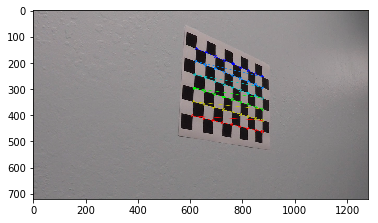

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)
        plt.imshow(img)
# cv2.destroyAllWindows()

## 2. Apply a distortion correction to raw images.

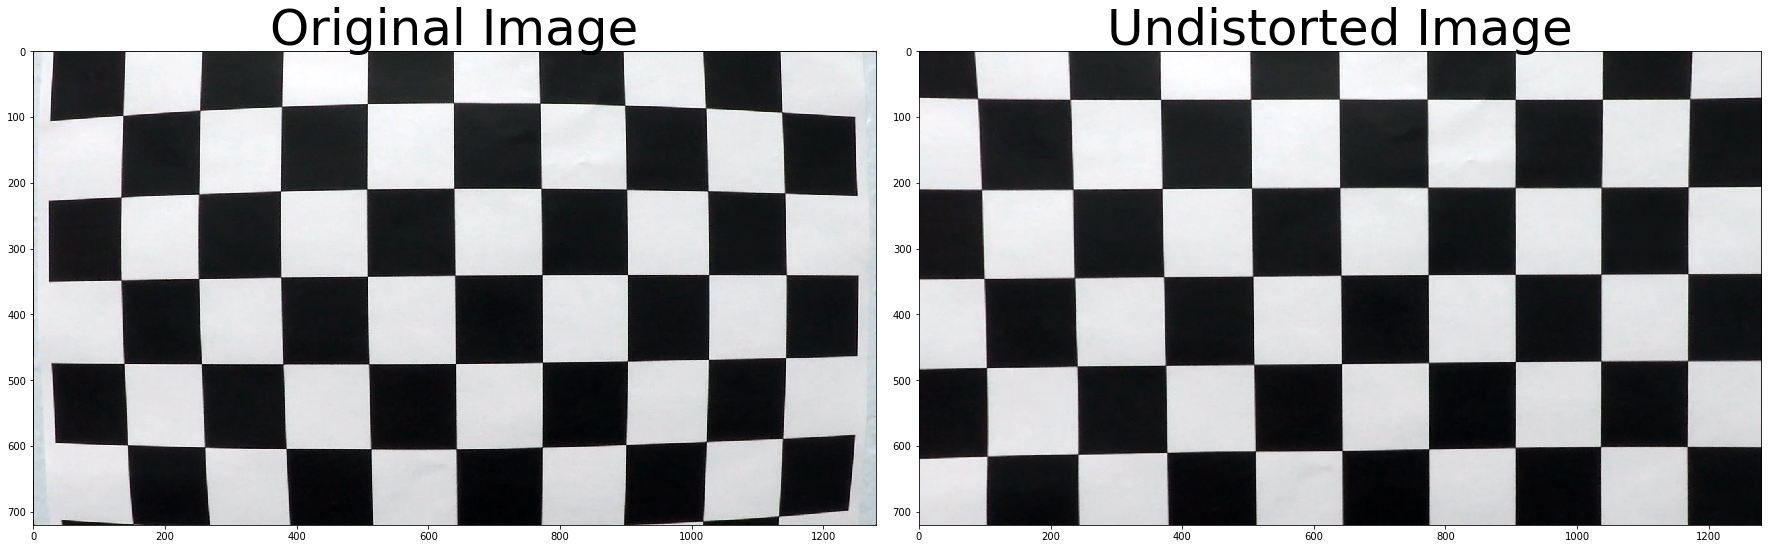

In [7]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


#========================================
#Test and show result
img = cv2.imread("./camera_cal/calibration1.jpg")

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

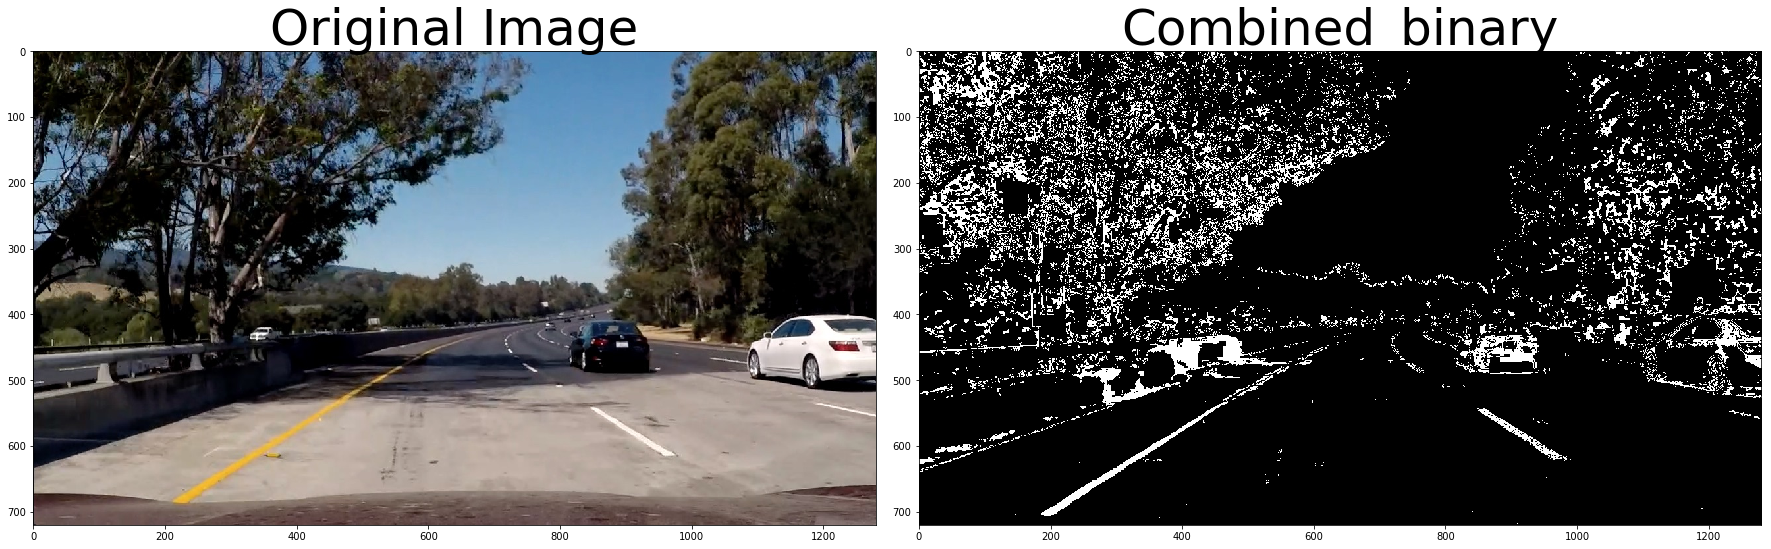

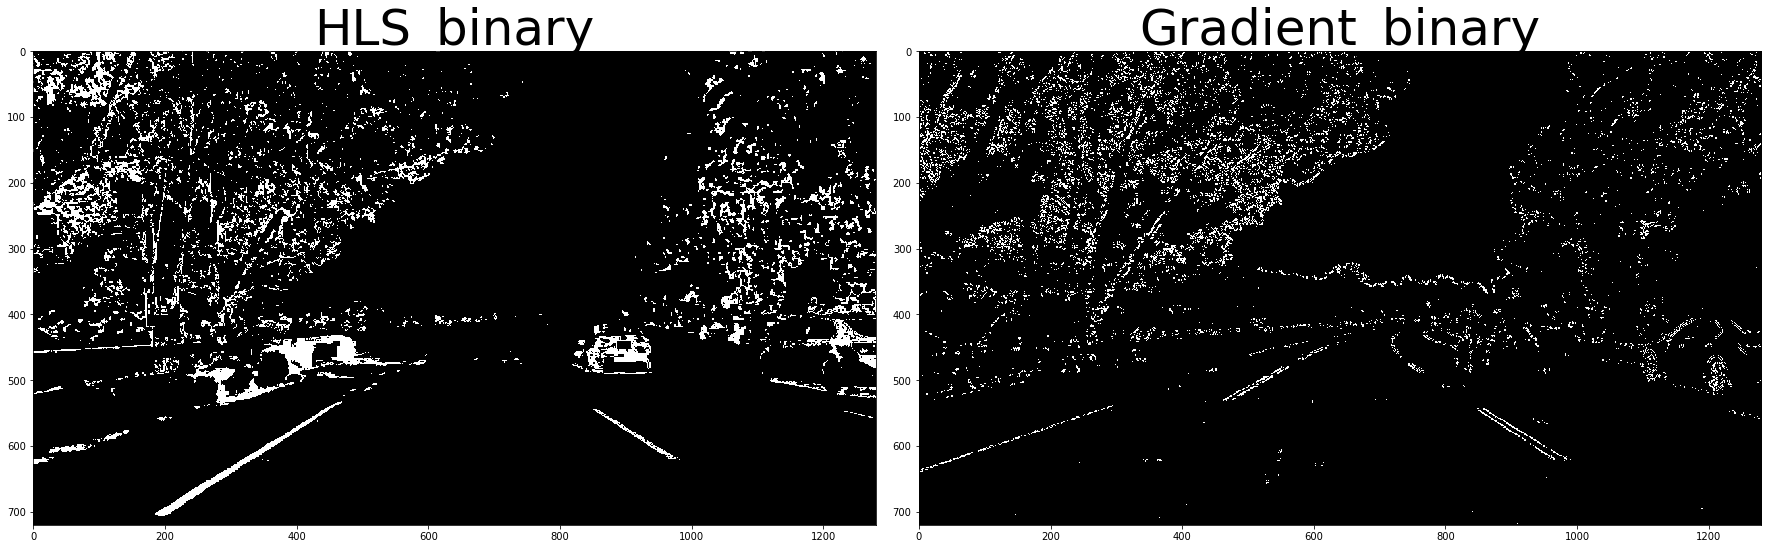

In [38]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_factor = np.max(abs_sobel)/255
    scaled_sobel = np.uint8(abs_sobel/scale_factor)
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your grad_binary image
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    #1 Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    #2 Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    
    #3 Calculate the gradient magnitude
    grad_mag = np.sqrt(sobelx**2, sobely**2)
    
    #4 Rescale to 8 bit
    scale_factor = np.max(grad_mag)/255
    grad_mag = (grad_mag/scale_factor).astype(np.uint8)
    
    #5 Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(grad_mag)
    mag_binary[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(abs_grad_dir)
    
    # 6) Return this mask as your dir_binary image
    dir_binary[(abs_grad_dir >= thresh[0])&(abs_grad_dir <= thresh[1])] = 1
    
    return dir_binary

def comine_gradient_threshold(image, sobel_kernel=3, abs_sobel_thresh=(0, 255), mag_thresh=(0, 255),
                                    dir_threshold=(0, np.pi/2)):
    #1 Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    
    #Absolute gradient in x and y
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    scaled_sobelx = np.uint8(abs_sobelx*255/np.max(abs_sobelx))
    scaled_sobely = np.uint8(abs_sobely*255/np.max(abs_sobely))

    #Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    #Calculate the gradient magnitude
    grad_mag = np.sqrt(sobelx**2, sobely**2)
    scale_factor = np.max(grad_mag)/255
    grad_mag = (grad_mag/scale_factor).astype(np.uint8)
    
    combined_binary = np.zeros_like(grad_mag)
    
#     combined_binary[((scaled_sobelx >= abs_sobel_thresh[0]) & (scaled_sobelx <= abs_sobel_thresh[1])) ] = 1
    combined_binary[(((scaled_sobelx >= abs_sobel_thresh[0]) & (scaled_sobelx <= abs_sobel_thresh[1])) 
                        & (((scaled_sobely >= abs_sobel_thresh[0]) & (scaled_sobely <= abs_sobel_thresh[1])))) ] = 1
    
#     combined_binary[(((scaled_sobelx >= abs_sobel_thresh[0]) & (scaled_sobelx <= abs_sobel_thresh[1])) 
#                         & (((scaled_sobely >= abs_sobel_thresh[0]) & (scaled_sobely <= abs_sobel_thresh[1])))) 
#                         | (((grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])) 
#                         & ((abs_grad_dir >= dir_threshold[0])&(abs_grad_dir <= dir_threshold[1])))] = 1

    return combined_binary
    
# Read in an image
img = mpimg.imread('./test_images/test5.jpg') 
# img = mpimg.imread('./test_images/straight_lines2.jpg') 
undistorted = cal_undistort(img, objpoints, imgpoints)

gradient_binary = comine_gradient_threshold(undistorted, sobel_kernel=3, abs_sobel_thresh=(20, 100),
                                                  mag_thresh=(30, 100), dir_threshold=(0.7, 1.3))

s_thresh_min = 170
s_thresh_max = 255


hls_binary = helpers.hls_select(undistorted, thresh=(s_thresh_min, s_thresh_max))

combined_binary = np.zeros_like(gradient_binary)
combined_binary[(hls_binary == 1) | (gradient_binary == 1)] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
# ax1.imshow(hls_binary, cmap='gray')
# ax1.imshow(gradient_binary, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined_binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# # Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(hls_binary, cmap='gray')
ax1.set_title('HLS_binary', fontsize=50)
ax2.imshow(gradient_binary, cmap='gray')
ax2.set_title('Gradient_binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view")

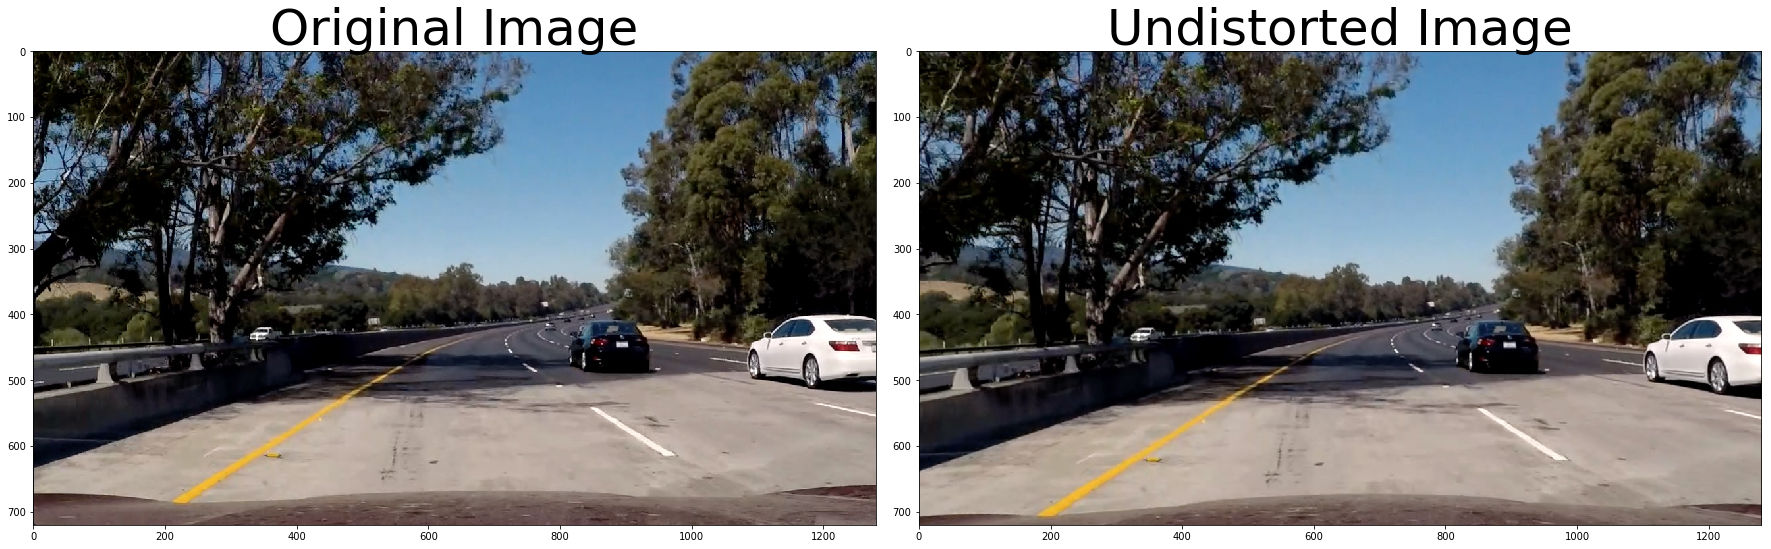

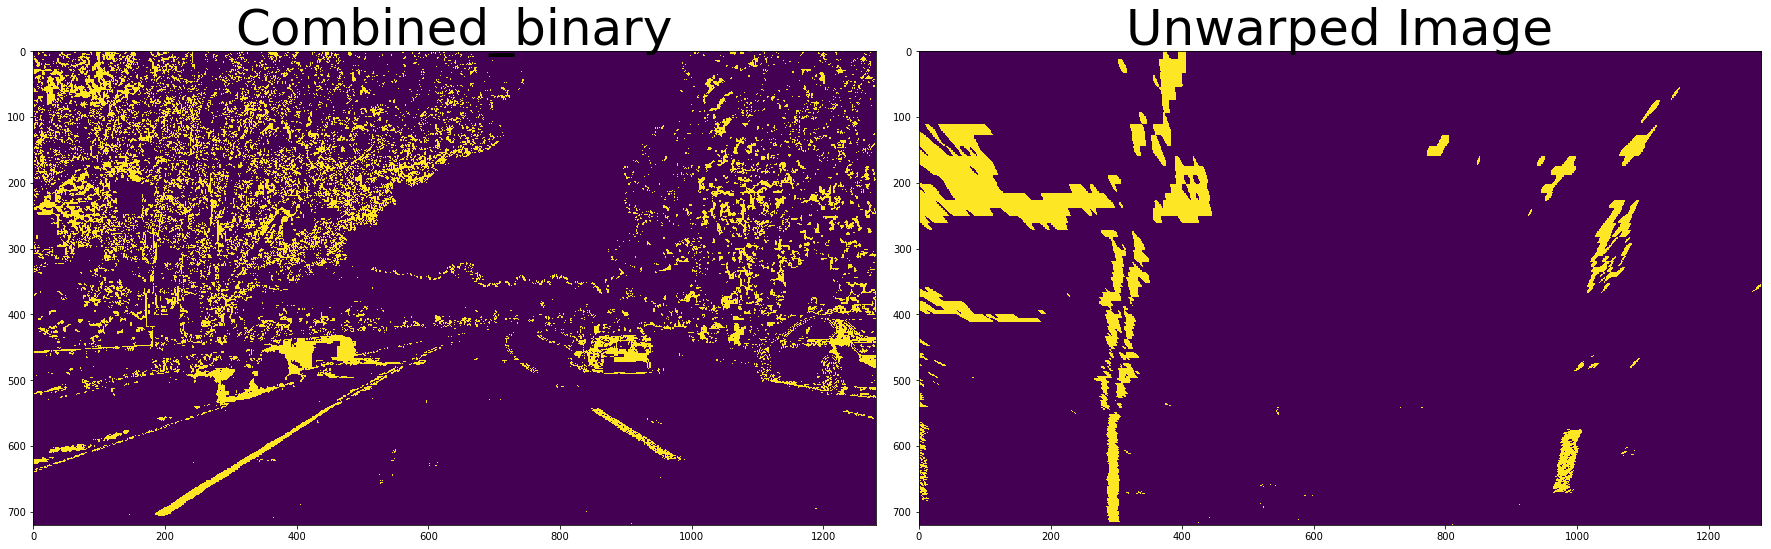

In [40]:
# print(combined_binary.shape)
# print(combined_binary)
# undistorted = cal_undistort(combined_binary, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def unwarp(undist):
    offset = 100

    img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
#     src = np.float32([[450,400], [830, 400], [1190, 720], [90, 720]])
    
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
#     dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
#                                  [img_size[0]-offset, img_size[1]-offset], 
#                                  [offset, img_size[1]-offset]])
    
#     dst = np.float32([[450,0], [830, 0], [1190, 720], [90, 720]])
#     dst = np.float32([[0,0], [1280, 0], [1190, 720], [90, 720]])

    #src = np.float32([[470,680], [810, 680], [1170, 720], [110, 720]])
    #dst = np.float32([[450,0], [830, 0], [1190, 720], [90, 720]])
    
    src = np.float32([[(203, 720), (585, 460), (695, 460), (1127, 720)]])
    dst = np.float32([[(320, 720), (320, 0), (960, 0), (960, 720)]])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inverse = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size)

    return warped, M_inverse

unwarped_img, M_inverse = unwarp(combined_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary)
ax1.set_title('Combined_binary', fontsize=50)
ax2.imshow(unwarped_img)
ax2.set_title('Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


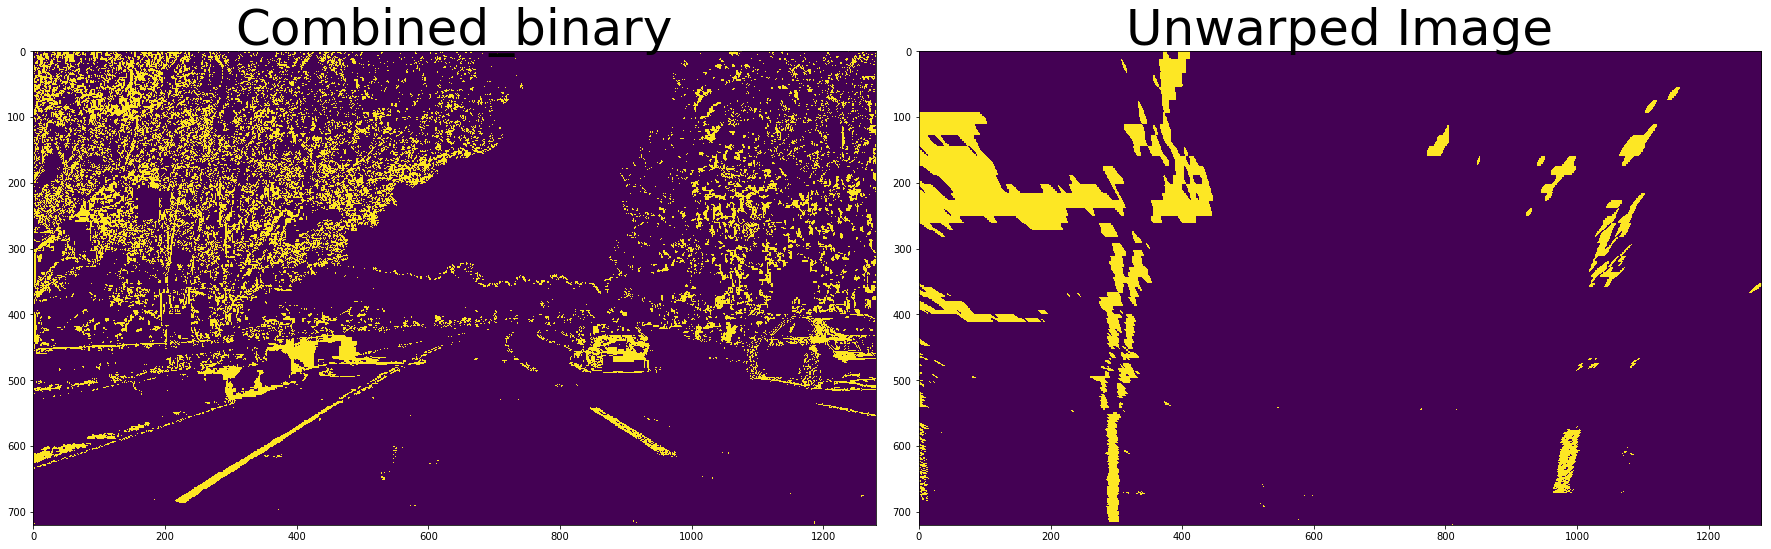

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary)
ax1.set_title('Combined_binary', fontsize=50)
ax2.imshow(unwarped_img)
ax2.set_title('Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 5. Detect lane pixels and fit to find the lane boundary

In [22]:
left_lane_inds_global = []
right_lane_inds_global = []

========left_lane_inds1:
[50984 50985 50986 ...  2692  2693  2694]


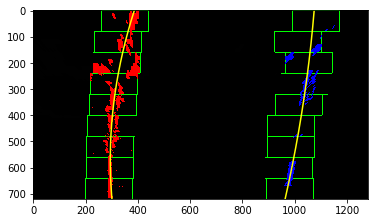

In [41]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 180
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin//2  # Update this
        win_xleft_high = leftx_current + margin//2  # Update this
        win_xright_low = rightx_current - margin//2  # Update this
        win_xright_high = rightx_current + margin//2  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = (np.where((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)\
                          &(nonzerox >= win_xleft_low)&(nonzerox <= win_xleft_high)))[0]

        good_right_inds = (np.where((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)\
                          &(nonzerox >= win_xright_low)&(nonzerox <= win_xright_high)))[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if(len(good_left_inds) > minpix ):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
#             print("========leftx_current:{}".format(leftx_current))
            
        if(len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
#             print("========rightx_current:{}".format(rightx_current))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        global left_lane_inds_global
        left_lane_inds_global = left_lane_inds
        
        global right_lane_inds_global
        right_lane_inds_global = right_lane_inds
        
        print("========left_lane_inds1:")
        print(left_lane_inds)
        
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print("========Error")

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    #second order polynomial work
    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty,rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        print("========Error")
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    
    return out_img, binary_warped, left_fitx, right_fitx, ploty

binary_warped = unwarped_img
out_img, warped, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)

# mpimg.imsave("out_img.png", out_img)

plt.imshow(out_img)
# plt.savefig('warped_example_output.png',dpi=400,bbox_inches='tight')

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.imshow(binary_warped)
# ax1.set_title('Binary_warped', fontsize=50)
# ax2.imshow(out_img)
# ax2.set_title('Out Image', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 6. Determine the curvature of the lane and vehicle position with respect to center

## 7. Warp the detected lane boundaries back onto the original image

(720, 1280, 3)


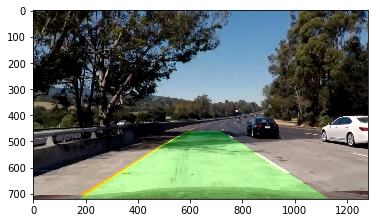

In [43]:
def draw_lane_lines_onto_origin(image, undist, warped, left_fitx, right_fitx, ploty, M_inverse):
    # Create an image to draw the lines on
    print(image.shape)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inverse, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result


result = draw_lane_lines_onto_origin(img, undistorted, warped, left_fitx, right_fitx, ploty, M_inverse)

plt.imshow(result)
plt.savefig('warped_output.png',dpi=400,bbox_inches='tight')    

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position